### Import Library

In [28]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import hashlib
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

### Laod Dataset

In [2]:
train_dir='../datasets/Training'
test_dir='../datasets/Testing'

### Data Understanding

Cek kelas tersedia

In [3]:
classes = os.listdir(train_dir)
print(f"Kelas yang tersedia: {classes}")

Kelas yang tersedia: ['glioma', 'meningioma', 'notumor', 'pituitary']


Buat Dataframe

In [4]:
train_counts = {}
test_counts = {}

for cls in classes:
    train_path = os.path.join(train_dir, cls)
    test_path = os.path.join(test_dir, cls)

    train_counts[cls] = len(os.listdir(train_path))
    test_counts[cls] = len(os.listdir(test_path))
    
df = pd.DataFrame({
    'Class': classes,
    'Train': [train_counts[cls] for cls in classes],
    'Test': [test_counts[cls] for cls in classes]
})

Distribusi Jumlah Data per Kelas (Train vs Test)

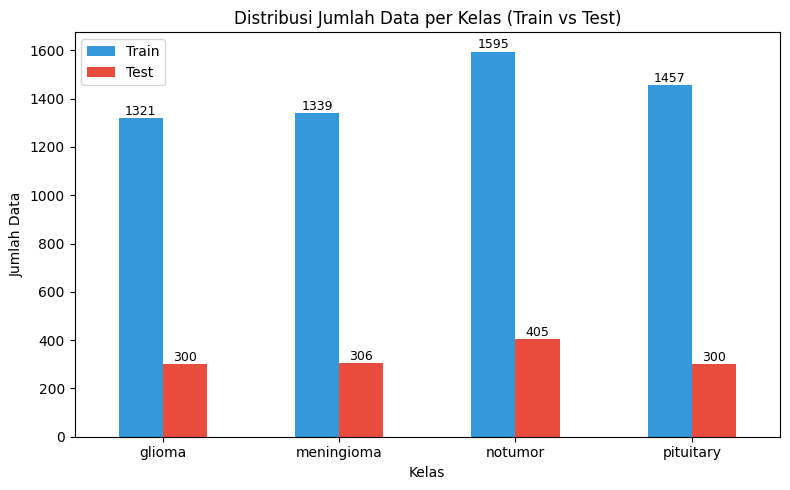

In [5]:
ax = df.set_index('Class')[['Train', 'Test']].plot(
    kind='bar',
    figsize=(8,5),
    color=['#3498db', '#e74c3c']
)

plt.title('Distribusi Jumlah Data per Kelas (Train vs Test)')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.xticks(rotation=0)
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 1,
        int(height),
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.show()

Distribusi Persentase Data per Kelas (Train Set)

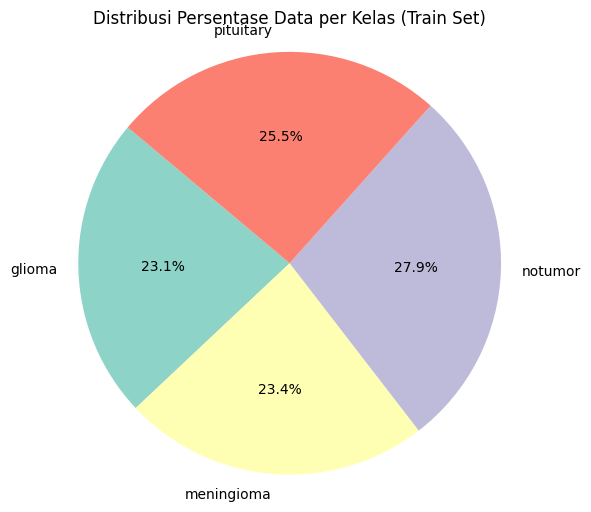

In [6]:
plt.figure(figsize=(6,6))
plt.pie(df['Train'], labels=df['Class'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
plt.title("Distribusi Persentase Data per Kelas (Train Set)")
plt.axis('equal')
plt.show()

Distribusi Persentase Data per Kelas (Test Set)

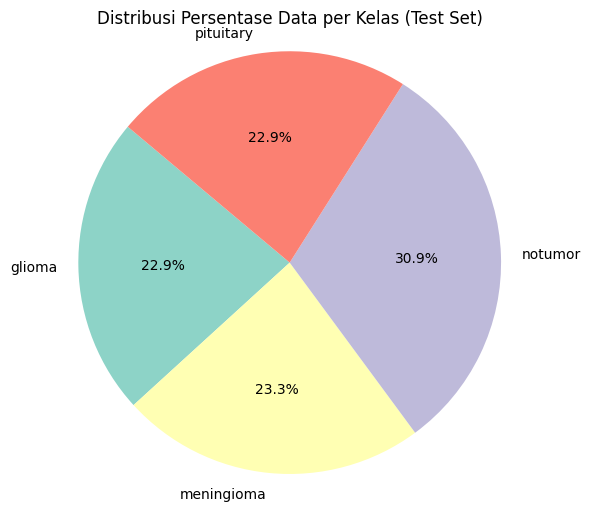

In [7]:
plt.figure(figsize=(6,6))
plt.pie(df['Test'], labels=df['Class'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
plt.title("Distribusi Persentase Data per Kelas (Test Set)")
plt.axis('equal')
plt.show()

Cek Karakteristik Gambar

In [8]:
sizes, modes = [], []

for cls in classes:
    path = os.path.join(train_dir, cls)
    for img in os.listdir(path):
        image = Image.open(os.path.join(path, img))
        sizes.append(image.size)
        modes.append(image.mode)

print("Resolusi unik:", Counter(sizes))
print("Tipe warna:", Counter(modes))

Resolusi unik: Counter({(512, 512): 3955, (225, 225): 268, (630, 630): 77, (236, 236): 53, (201, 251): 43, (228, 221): 38, (300, 168): 38, (442, 442): 37, (150, 198): 36, (232, 217): 35, (428, 417): 33, (200, 252): 32, (173, 201): 30, (206, 244): 28, (192, 192): 27, (256, 256): 26, (201, 250): 26, (218, 231): 23, (215, 234): 22, (227, 222): 22, (468, 444): 20, (214, 236): 20, (227, 262): 19, (208, 242): 18, (504, 540): 18, (359, 449): 17, (236, 213): 17, (400, 442): 16, (550, 664): 16, (642, 361): 15, (230, 282): 15, (393, 400): 14, (207, 243): 14, (441, 442): 14, (235, 214): 14, (680, 680): 13, (420, 280): 13, (442, 454): 13, (276, 326): 12, (339, 340): 12, (350, 350): 11, (196, 257): 11, (194, 259): 10, (212, 238): 9, (220, 275): 9, (356, 474): 8, (235, 227): 7, (177, 197): 7, (380, 530): 7, (275, 183): 7, (350, 393): 6, (236, 260): 5, (236, 357): 5, (1024, 1024): 5, (236, 251): 4, (236, 295): 4, (235, 229): 4, (236, 243): 4, (236, 262): 4, (236, 269): 4, (234, 218): 4, (416, 512): 4

Cek Duplikat dan File Corrupt

In [9]:
def check_duplicates_and_corrupt(data_dir):
    hashes, duplicates, corrupt = set(), [], []
    for cls in os.listdir(data_dir):
        path = os.path.join(data_dir, cls)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            try:
                with open(img_path, "rb") as f:
                    h = hashlib.md5(f.read()).hexdigest()
                if h in hashes:
                    duplicates.append(img_path)
                else:
                    hashes.add(h)
            except:
                corrupt.append(img_path)
    return duplicates, corrupt

train_duplicates, train_corrupt = check_duplicates_and_corrupt(train_dir)

print(f"Duplikat di Train : {len(train_duplicates)} file")
print(f"File Corrupt Train: {len(train_corrupt)} file")

Duplikat di Train : 191 file
File Corrupt Train: 0 file


Cek Histogram Intensitas (Brightness & Contrast)

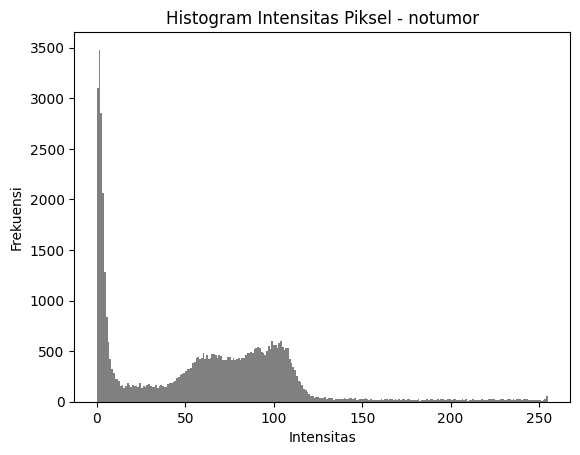

In [10]:
sample_cls = random.choice(classes)
sample_img = random.choice(os.listdir(os.path.join(train_dir, sample_cls)))
img_path = os.path.join(train_dir, sample_cls, sample_img)

gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.hist(gray.ravel(), bins=256, color='gray')
plt.title(f"Histogram Intensitas Piksel - {sample_cls}")
plt.xlabel("Intensitas")
plt.ylabel("Frekuensi")
plt.show()

Visualisasi sample gambar

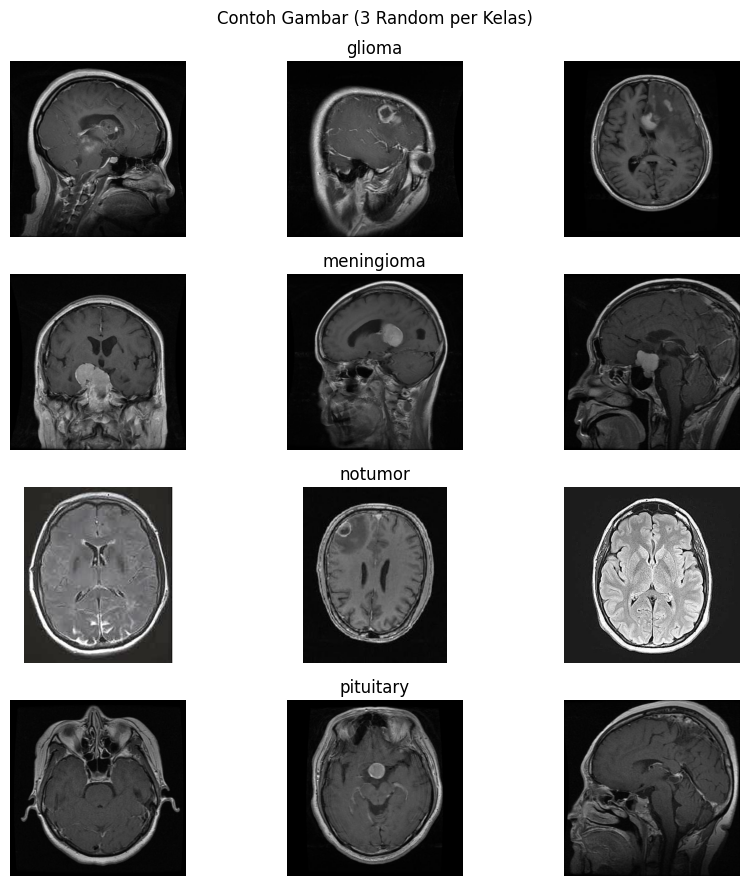

In [11]:
fig, axes = plt.subplots(len(classes), 3, figsize=(9, 9))
for i, cls in enumerate(classes):
    path = os.path.join(train_dir, cls)
    for j in range(3):
        img = random.choice(os.listdir(path))
        image = Image.open(os.path.join(path, img))
        axes[i, j].imshow(image, cmap='gray')
        axes[i, j].set_title(cls if j==1 else "")
        axes[i, j].axis('off')
plt.suptitle("Contoh Gambar (3 Random per Kelas)")
plt.tight_layout()
plt.show()

Ringkasan Insight

In [12]:
insight_summary = {
    "Total Train Gambar": df['Train'].sum(),
    "Total Test Gambar": df['Test'].sum(),
    "Jumlah Kelas": len(classes),
    "Kelas dengan Train Terbanyak": f"{df.loc[df['Train'].idxmax(), 'Class']} ({df['Train'].max()} gambar)",
    "Kelas dengan Train Tersedikit": f"{df.loc[df['Train'].idxmin(), 'Class']} ({df['Train'].min()} gambar)",
    "Resolusi Unik": f"{len(Counter(sizes))} jenis (contoh: {list(Counter(sizes).keys())[:1]})",
    "Tipe Warna": dict(Counter(modes)),
    "Duplikat di Train": f"{len(train_duplicates)} file",
    "File Corrupt di Train": f"{len(train_corrupt)} file",
}

insight_df = pd.DataFrame(list(insight_summary.items()), columns=["Deskripsi", "Hasil"])
display(insight_df)

,Deskripsi,Hasil
0,Total Train Gambar,5712
1,Total Test Gambar,1311
2,Jumlah Kelas,4
3,Kelas dengan Train Terbanyak,notumor (1595 gambar)
4,Kelas dengan Train Tersedikit,glioma (1321 gambar)
5,Resolusi Unik,"382 jenis (contoh: [(512, 512)])"
6,Tipe Warna,"{'RGB': 3236, 'L': 2472, 'RGBA': 3, 'P': 1}"
7,Duplikat di Train,191 file
8,File Corrupt di Train,0 file


### Data Preparation

Image size

In [13]:
img_size = (150, 150)
batch_size = 32

Data Cleaning - Hapus Data Duplikat

In [14]:
def remove_duplicates(data_dir):
    hashes = {}
    duplicates = []
    for cls in os.listdir(data_dir):
        path = os.path.join(data_dir, cls)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            try:
                with open(img_path, "rb") as f:
                    h = hashlib.md5(f.read()).hexdigest()
                if h in hashes:
                    os.remove(img_path)
                    duplicates.append(img_path)
                else:
                    hashes[h] = img_path
            except:
                pass
    print(f"{len(duplicates)} file duplikat dihapus dari {data_dir}")

remove_duplicates(train_dir)

191 file duplikat dihapus dari ../datasets/Training


Distribusi Data Setelah Cleaning

In [15]:
classes = os.listdir(train_dir)
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}

df = pd.DataFrame({
    'Class': classes,
    'Train': [train_counts[c] for c in classes]
})

print(df)
print("Total Train:", df['Train'].sum())

        Class  Train
0      glioma   1321
1  meningioma   1333
2     notumor   1422
3   pituitary   1445
Total Train: 5521


Data Transformation & Augmentation

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    brightness_range=(0.85, 1.15),
    width_shift_range=0.002,
    height_shift_range=0.002,
    shear_range=12.5,
    zoom_range=0,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)

Data Splitting (Train & Test)

In [17]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=111
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=111
)

Found 5521 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


### Modeling

Arsitektur model

In [18]:
model = Sequential([
    Conv2D(32, (4,4), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(pool_size=(4,4)),

    Conv2D(64, (4,4), activation='relu'),
    MaxPooling2D(pool_size=(4,4)),

    Conv2D(128, (4,4), activation='relu'),
    MaxPooling2D(pool_size=(4,4)),
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5, seed=111),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 33, 33, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,700 (912.89 KB)

 Trainable params: 233,700 (912.89 KB)

 Non-trainable params: 0 (0.00 B)

Callback model

In [19]:
# Callback early stop
early_stop = EarlyStopping(
    monitor='loss', 
    min_delta=1e-9, 
    patience=8, 
    verbose=True
)

# Callback reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3, 
    patience=5, 
    verbose=True
)

Training model

In [20]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    validation_steps=178,
    callbacks=[early_stop, reduce_lr]
)

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 72s 402ms/step - accuracy: 0.4516 - loss: 1.1404 - val_accuracy: 0.6804 - val_loss: 0.8161 - learning_rate: 0.0010
Epoch 2/30


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


173/173 ━━━━━━━━━━━━━━━━━━━━ 57s 330ms/step - accuracy: 0.7354 - loss: 0.6546 - val_accuracy: 0.7399 - val_loss: 0.6453 - learning_rate: 0.0010
Epoch 3/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 66s 379ms/step - accuracy: 0.7914 - loss: 0.5307 - val_accuracy: 0.6331 - val_loss: 1.0121 - learning_rate: 0.0010
Epoch 4/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 106s 517ms/step - accuracy: 0.8310 - loss: 0.4404 - val_accuracy: 0.7933 - val_loss: 0.5627 - learning_rate: 0.0010
Epoch 5/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 63s 363ms/step - accuracy: 0.8644 - loss: 0.3505 - val_accuracy: 0.8185 - val_loss: 0.5136 - learning_rate: 0.0010
Epoch 6/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 68s 395ms/step - accuracy: 0.8885 - loss: 0.2867 - val_accuracy: 0.9130 - val_loss: 0.2773 - learning_rate: 0.0010
Epoch 7/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 65s 377ms/step - accuracy: 0.9123 - loss: 0.2393 - val_accuracy: 0.9115 - val_loss: 0.2590 - learning_rate: 0.0010
Epoch 8/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 65s 378ms/step - accuracy: 0.9145 - loss

### Evaluation

Training dan validasi selama ephocs 

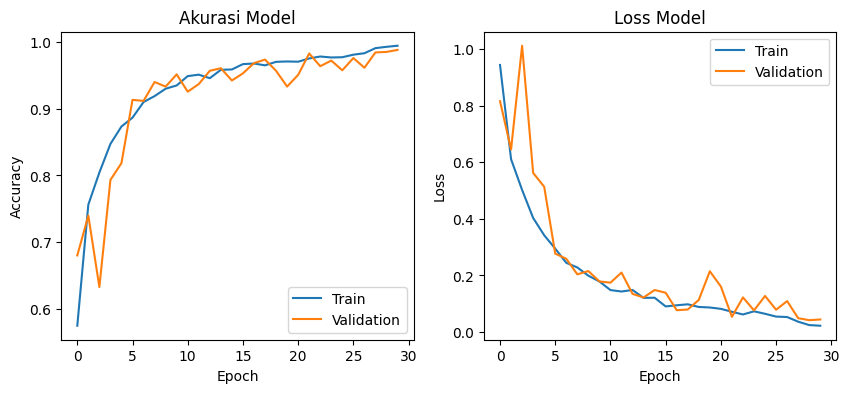

In [21]:
# Plot akurasi
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Persiapan data evaluasi

In [22]:
# Ambil prediksi
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Ambil label asli
y_true = test_generator.classes

# Ambil nama kelas
class_names = list(test_generator.class_indices.keys())

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step


Classification Report

In [23]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.97      0.99       300
  meningioma       0.97      0.98      0.97       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



Confusion Matrix

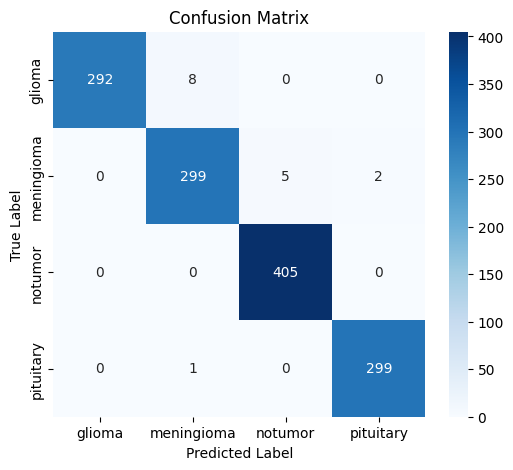

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


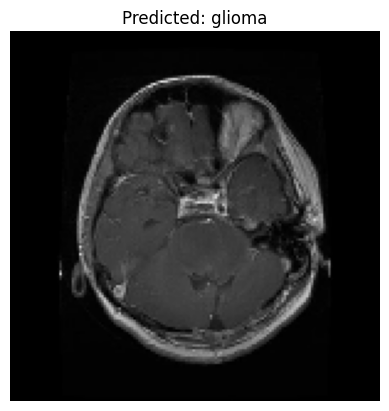

In [33]:
path_glioma = test_dir + "/glioma/Te-gl_0010.jpg"
path_meningioma = test_dir + "/meningioma/Te-me_0012.jpg"
path_pituitary = test_dir + "/pituitary/Te-pi_0010.jpg"
path_notumor = test_dir + "/notumor/Te-no_0010.jpg"

path_test = path_glioma

class_labels = list(train_generator.class_indices.keys())
sample_img_path = path_test

img = image.load_img(sample_img_path, target_size=img_size)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(prediction)]

plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()


### Model Save

Model .h5

In [26]:
model.save('../output/neuroinsight.h5')